## Salt Lake Problem

The salt lake problem was suggested by Simmons 1999 as a comprehensive benchmark
test for variable-density groundwater flow models. The problem is based on dense
salt fingers that descend from an evaporating salt lake. Although an analytical
solution is not available for the salt lake problem, an equivalent Hele-Shaw
analysis was performed in the laboratory to investigate the movement of dense
salt fingers Wooding 1997. In addition to the SUTRA simulation, this salt lake
problem was simulated by Langevin et al 2003 using SEAWAT-2000. The approach
described by Langevin et al 2003 is reproduced here with MODFLOW 6.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-saltlake"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)
gif_save = get_env("GIF", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "mm"
time_units = "seconds"

# Model parameters
nper = 1  # Number of periods
nstp = 400  # Number of time steps
perlen = 24000  # Simulation time length ($s$)
nlay = 57  # Number of layers
nrow = 1  # Number of rows
ncol = 135  # Number of columns
system_length = 150.0  # Length of system ($mm$)
delr_str = "ranges from 0.75 to 1.5"  # Column width ($mm$)
delc = 1.5  # Row width ($mm$)
delv_str = "ranges from 0.75 to 1.5"  # Layer thickness
top = 75.0  # Top of the model ($mm$)
hydraulic_conductivity = 3.05  # Hydraulic conductivity ($mm s^{-1}$)
ss = 3.8e-10  # Specific storage ($mm^{-1}$)
denseref = 0.001065  # Reference density
denseslp = 0.646  # Density and concentration slope
conc_inflow = 8.4e-5  # Initial and inflow concentration ($g L^{-1}$)
conc_sat = 1.1e-4  # Saturated concentration ($g L^{-1}$)
porosity = 1.0  # Porosity (unitless)
evap_rate = 1.03e-3  # Evaporation rate ($mm s^{-1}$)
alphal = 9.0e-7  # Longitudinal dispersivity ($mm$)
alphat = 9.0e-7  # Transverse dispersivity ($mm$)
diffc = 9.0e-4  # Diffusion coefficient ($mm s^{-1}$)

delv = 14 * [0.75] + 43 * [1.5]
delr = 70 * [0.75] + 65 * [1.5]
tp = top
botm = []
for k in range(nlay):
    bt = tp - delv[k]
    botm.append(bt)
    tp = bt

nouter, ninner = 100, 300
hclose, rclose, relax = 1e-8, 1e-8, 0.97

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_folder):
    print(f"Building model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder)
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
    )
    tdis_ds = ((perlen, nstp, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwf.name}.ims",
    )
    sim.register_ims_package(ims, [gwf.name])
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfsto(gwf, ss=ss)
    flopy.mf6.ModflowGwfic(gwf, strt=top)
    pd = [(0, denseslp, 0.0, "trans", "concentration")]
    flopy.mf6.ModflowGwfbuy(gwf, denseref=denseref, packagedata=pd)
    chdspd = [[(0, 0, j), top, conc_inflow] for j in range(101, ncol)]
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chdspd,
        pname="CHD-1",
        auxiliary="CONCENTRATION",
    )
    rchspd = [[(0, 0, j), -evap_rate] for j in range(0, 67)]
    flopy.mf6.ModflowGwfrch(
        gwf,
        stress_period_data=rchspd,
        pname="RCH-1",
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    gwt = flopy.mf6.ModflowGwt(sim, modelname="trans")
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwt.name}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtic(gwt, strt=conc_inflow)
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=alphal, ath1=alphat, diffc=diffc)
    sourcerecarray = [
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    conc_rand = (np.random.random(67) - 0.5) * 0.01 * (
        conc_sat - conc_inflow
    ) + conc_sat
    cncspd = [[(0, 0, j), conc_rand[j]] for j in range(0, 67)]
    flopy.mf6.ModflowGwtcnc(
        gwt,
        stress_period_data=cncspd,
        pname="CNC-1",
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwt.name}.cbc",
        concentration_filerecord=f"{gwt.name}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "ALL")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    flopy.mf6.ModflowGwfgwt(
        sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 8)


def plot_conc(sim, idx):
    with styles.USGSMap():
        sim_name = example_name
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")

        # make bc figure
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        pxs.plot_grid(linewidth=0.1)
        pxs.plot_bc("RCH-1", color="red")
        pxs.plot_bc("CHD-1", color="blue")
        ax.set_ylabel("z position (m)")
        ax.set_xlabel("x position (m)")
        if plot_save:
            fpth = figs_path / f"{sim_name}-bc.png"
            fig.savefig(fpth)
        plt.close("all")

        # make results plot
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        # create MODFLOW 6 head object
        cobj = gwt.output.concentration()
        times = cobj.get_times()
        times = np.array(times)

        # plot times in the original publication
        plot_times = [
            2581.0,
            15485.0,
            5162.0,
            18053.0,
            10311.0,
            20634.0,
            12904.0,
            23215.0,
        ]

        nplots = len(plot_times)
        for iplot in range(nplots):
            time_in_pub = plot_times[iplot]
            idx_conc = (np.abs(times - time_in_pub)).argmin()
            time_this_plot = times[idx_conc]
            conc = cobj.get_data(totim=time_this_plot)

            ax = fig.add_subplot(4, 2, iplot + 1)
            pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
            pxs.plot_array(conc, cmap="jet", vmin=conc_inflow, vmax=conc_sat)
            ax.set_xlim(0, 75.0)
            ax.set_ylabel("z position (m)")
            if iplot in [6, 7]:
                ax.set_xlabel("x position (m)")
            ax.set_title(f"Time = {time_this_plot} seconds")
        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-conc.png"
            fig.savefig(fpth)


def make_animated_gif(sim, idx):
    from matplotlib.animation import FuncAnimation, PillowWriter

    with styles.USGSMap():
        sim_name = example_name
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")

        cobj = gwt.output.concentration()
        times = cobj.get_times()
        times = np.array(times)
        conc = cobj.get_alldata()

        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        pc = pxs.plot_array(conc[0], cmap="jet", vmin=conc_inflow, vmax=conc_sat)

        def init():
            ax.set_xlim(0, 75.0)
            ax.set_ylim(0, 75.0)
            ax.set_title(f"Time = {times[0]} seconds")

        def update(i):
            pc.set_array(conc[i].flatten())
            ax.set_title(f"Time = {times[i]} seconds")

        ani = FuncAnimation(fig, update, range(1, times.shape[0]), init_func=init)
        writer = PillowWriter(fps=50)
        fpth = figs_path / "{}{}".format(sim_name, ".gif")
        ani.save(fpth, writer=writer)


def plot_results(sim, idx):
    plot_conc(sim, idx)
    if plot_save and gif_save:
        make_animated_gif(sim, idx)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building model...ex-gwt-saltlake


run_models took 25332.06 ms


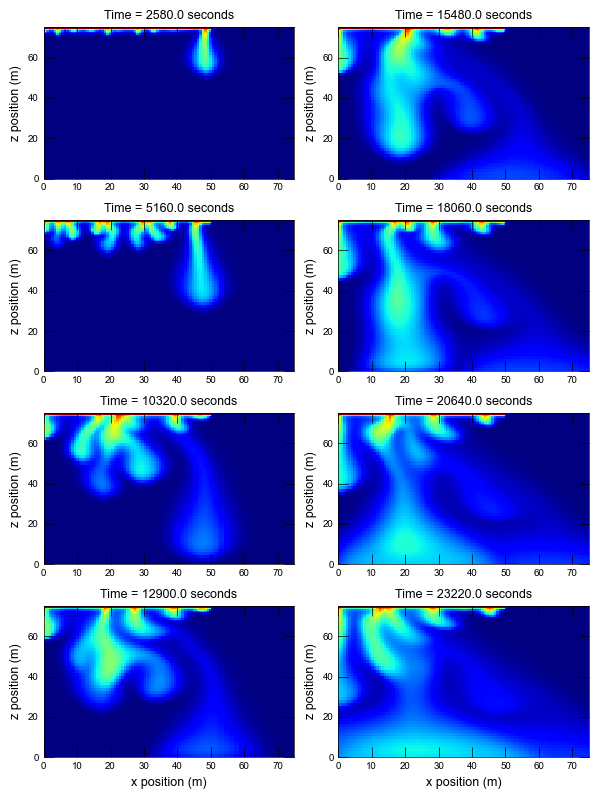

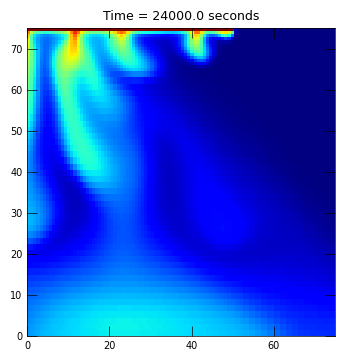

In [5]:
def scenario(idx, silent=True):
    sim = build_models(example_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


scenario(0)